In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
# Load the dataset from the correct path
with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

# Print the keys of the dictionary
print(data.keys())

# Print the unique values of the 'train_labels' key
train_labels = data['train_labels']
unique_values = np.unique(train_labels) if isinstance(train_labels, (list, np.ndarray)) else "Not a list or ndarray"
print(f"Unique values in 'train_labels': {unique_values}")
train_labels = data['test_labels']
unique_values = np.unique(train_labels) if isinstance(train_labels, (list, np.ndarray)) else "Not a list or ndarray"
print(f"Unique values in 'test_labels': {unique_values}")

dict_keys(['train_labels', 'train_images', 'test_labels', 'test_images'])
Unique values in 'train_labels': ['air-hole' 'bite-edge' 'broken-arc' 'crack' 'hollow-bead' 'overlap'
 'slag-inclusion' 'unfused']
Unique values in 'test_labels': ['air-hole' 'bite-edge' 'broken-arc' 'crack' 'hollow-bead' 'overlap'
 'slag-inclusion' 'unfused']


In [4]:
# Define constants
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128  # Changed image size for variety
CLASSES = ['air-hole', 'hollow-bead', 'slag-inclusion', 'bite-edge', 'broken-arc', 'crack', 'overlap', 'unfused']

def load_dataset_from_pkl(pkl_file, resize=(128, 128)):
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)
    
    train_images, train_labels = data['train_images'], data['train_labels']
    test_images, test_labels = data['test_images'], data['test_labels']
    
    # Create a mapping from class names to integers
    class_names = sorted(set(train_labels))
    class_to_int = {cls: idx for idx, cls in enumerate(class_names)}
    
    # Convert string labels to integers
    train_labels = np.array([class_to_int[label] for label in train_labels])
    test_labels = np.array([class_to_int[label] for label in test_labels])
    
    # Resize images if needed
    train_images_resized = np.array([cv2.resize(img, resize) for img in train_images])
    test_images_resized = np.array([cv2.resize(img, resize) for img in test_images])
    
    # Normalize images
    train_images_resized = train_images_resized / 255.0
    test_images_resized = test_images_resized / 255.0
    
    # Add a channels dimension
    train_images_resized = np.expand_dims(train_images_resized, axis=-1)
    test_images_resized = np.expand_dims(test_images_resized, axis=-1)
    
    return (train_labels, train_images_resized), (test_labels, test_images_resized), class_names

# Load the dataset
(train_labels, train_images), (test_labels, test_images), class_names = load_dataset_from_pkl('dataset.pkl', resize=(IMAGE_WIDTH, IMAGE_HEIGHT))


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [6]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 173ms/step - accuracy: 0.7341 - loss: 1.1773 - val_accuracy: 0.7711 - val_loss: 0.8739
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 191ms/step - accuracy: 0.7780 - loss: 0.8576 - val_accuracy: 0.8025 - val_loss: 0.6795
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.7964 - loss: 0.7028 - val_accuracy: 0.8345 - val_loss: 0.5970
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.8148 - loss: 0.6530 - val_accuracy: 0.8338 - val_loss: 0.5444
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 279ms/step - accuracy: 0.8399 - loss: 0.5675 - val_accuracy: 0.8571 - val_loss: 0.4861
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 287ms/step - accuracy: 0.8321 - loss: 0.5442 - val_accuracy: 0.8819 - val_loss: 0.4122
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - accuracy: 0.8514 - loss: 0.4786 - val_accuracy: 0.8819 - val_loss: 0.3747
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 277ms/step - accuracy: 0.8523 - loss: 0

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Length of test_images: 1372
Length of predictions: 1372
Length of test_labels: 1372
Length of predicted_classes: 1372


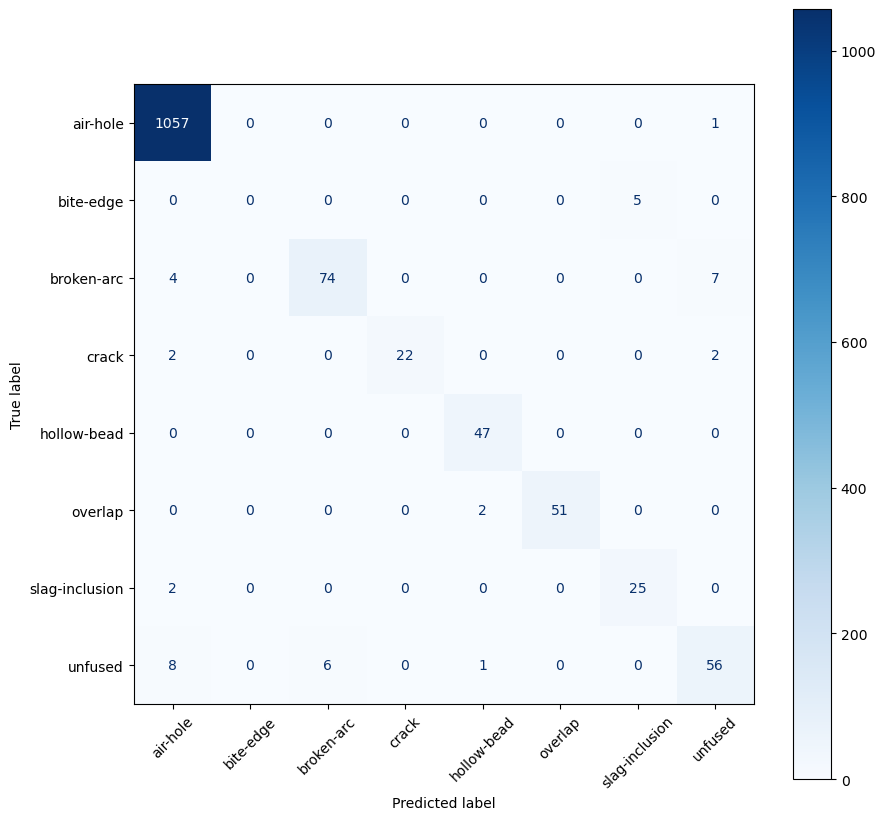

In [8]:
# Ensure predictions are generated for the entire test set
predictions = model.predict(test_images)

# Verify the length of predictions
print(f"Length of test_images: {len(test_images)}")
print(f"Length of predictions: {len(predictions)}")

# Predict the classes
predicted_classes = np.argmax(predictions, axis=1)

# Verify lengths
print(f"Length of test_labels: {len(test_labels)}")
print(f"Length of predicted_classes: {len(predicted_classes)}")

# Ensure the lengths match before proceeding
assert len(test_labels) == len(predicted_classes), "Mismatch in number of test labels and predictions"

# Compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

43/43 - 2s - 43ms/step - accuracy: 0.9708 - loss: 0.0902

Test accuracy: 0.9708454608917236


In [10]:
os.makedirs('results', exist_ok=True)
np.save('results/predictions.npy', predictions)

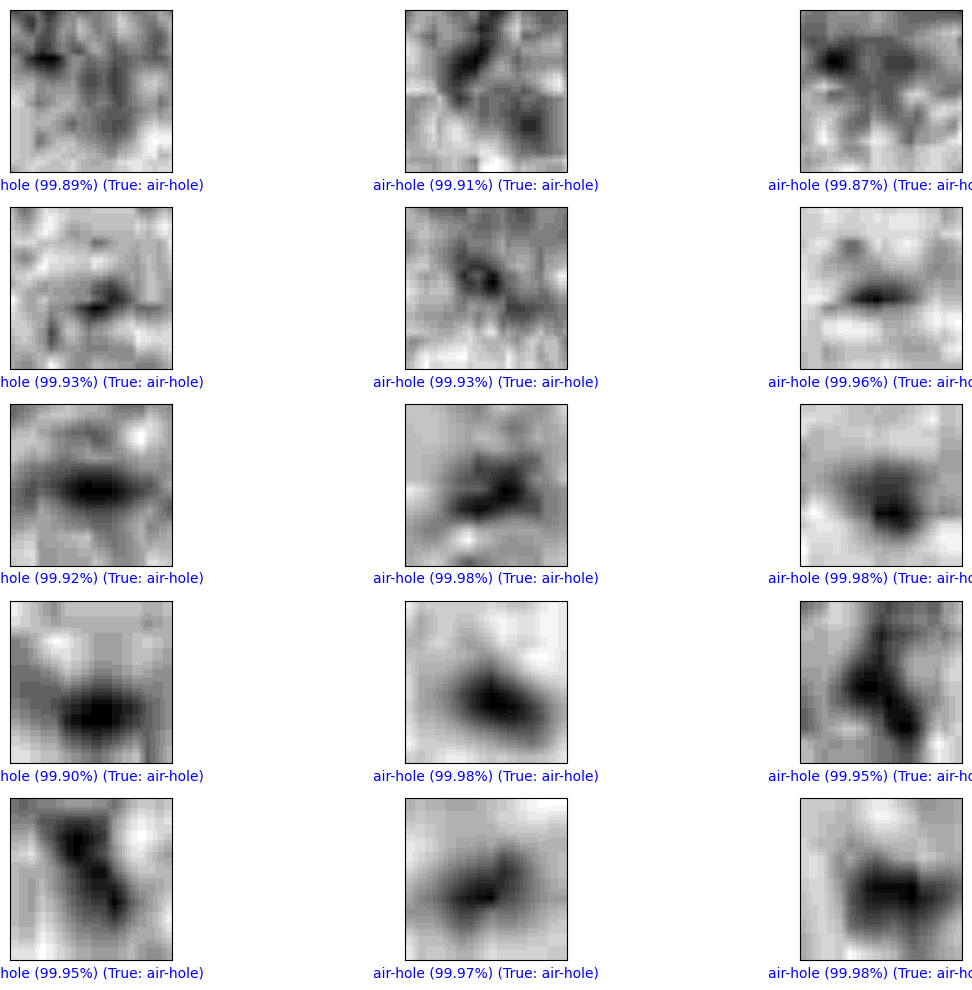

In [12]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Display the image
    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    # Get predicted label and confidence
    predicted_label = np.argmax(predictions_array)
    confidence = 100 * np.max(predictions_array)
    
    # Get the color for the text based on prediction accuracy
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    # Display the prediction result with confidence
    plt.xlabel(f"{class_names[predicted_label]} ({confidence:.2f}%) (True: {class_names[true_label]})", color=color)

# Plot the first X test images, their predicted labels, and the true labels
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
plt.tight_layout()
plt.show()


In [14]:
# Save the model using the native Keras format
model.save('model.keras')